In [30]:
#Dependencies
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.plotutils as plu
import utils.imreadin as imr

%matplotlib inline

In [38]:
#Model Parameters
compression = 10
patchsize = 16
batchsize = 100
iterations = 46000

#noise
noisexsigma = 0 #1e-4
noisersigma = 0 #1e-4

minact = 0.1 #5e-1
minslo = 0.1 #1e-1
#bslfr = 1e-1

learning_rate = 1

In [39]:
#Load in images if we haven't yet.

def loadimages(psz):
    print("Loading Van Hateren Natural Image Database...")
    vhimgs = imr.vanHateren(
        img_dir='../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5',
        normalize = True,
        patch_edge_size=psz
        )
    print("Done Loading!")    
    np.random.shuffle(vhimgs.images)
    print("Done Shuffling!")
    return(vhimgs, psz)

try:
    vhims
except NameError:
    vhims, loadedpatchsize = loadimages(patchsize)
    
if(patchsize != loadedpatchsize):
    vhims, loadedpatchsize = loadimages(patchsize)
       
print("Images Loaded.")

#params of images
imxlen = len(vhims.images[0,0,:])
imylen = len(vhims.images[0,:,0])
nimages = len(vhims.images[:,0,0])

nimstrained = batchsize * iterations

if(nimstrained > nimages):
    print('ERROR! Trying to train',nimstrained,'images, but we only have',nimages,'images!')
else:
    print('Training',nimstrained,'out of',nimages,'total image patches.')

Images Loaded.
Training 4600000 out of 4685824 total image patches.


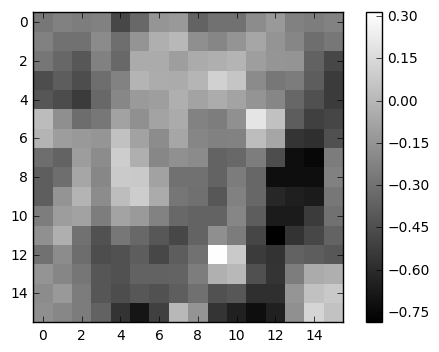

In [40]:
#show an example image
plt.imshow(vhims.images[5],cmap='gray',interpolation='none')
plt.colorbar()

In [41]:
nneurons = np.int(imxlen*imylen/compression)
print('Compressing by',compression,'for a total of',nneurons,'neurons')

#input image
x = tf.placeholder(tf.float32, shape=(batchsize, imxlen*imylen),name='input_image')
#output image
#xp = tf.placeholder(tf.float32, shape=(batchsize,imxlen*imylen),name='output_image')

#noise
nxc = noisexsigma**2
nrc = noisersigma**2
nx = tf.constant(nxc,dtype=tf.float32,name='input_noise')
nr = tf.constant(nrc,dtype=tf.float32,name='internal_noise')

#weights
win = tf.Variable(tf.random_normal([imxlen*imylen,nneurons],dtype=tf.float32,stddev=1),name='weights_in')
#wout = tf.placeholder(tf.float32, shape=np.shape(win),name='weights_out')

#calculate inner layer
y = tf.nn.tanh(tf.matmul(tf.add(x, nx),win))
#calculate ouer layer
xp = tf.nn.tanh(tf.matmul(y,tf.transpose(win)))
#calculate cost
cost = tf.sqrt(tf.reduce_mean(tf.square(x-xp)))

train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

Compressing by 10 for a total of 25 neurons


In [ ]:
#run it!
#sess = tf.Session
with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #save evolution of system over training
    cost_evolution = []
    weights_evolution = []
    
    hist = {}
    
    #train over niterations
    nits = iterations #full run
    
    print('Training {} iterations...'.format(nits))
    for ii in range(nits):
        if(ii%(int((nits)/10))==0):
            print(str(ii)+', ',end="")
        image = np.reshape(vhims.images[ii*batchsize:(1+ii)*batchsize,:,:],(batchsize,imxlen*imylen)).astype(np.float32)
        #noise_input = np.random.normal(0,noisexsigma,[patchsize**2,batchsize]).astype(np.float32)*0.
        #noise_response = np.random.normal(0,noisersigma,[nneurons,batchsize]).astype(np.float32)*0.
        hist[0] = image
        sess.run(train_step, feed_dict={x:image})
        
        #save evolution of params
        objcost = sess.run(cost, feed_dict={x:image})
        cost_evolution.append(objcost)
        weightsr = sess.run(win, feed_dict={x:image})
        weights_evolution.append(np.mean(weightsr))
        

    weights = sess.run(win, feed_dict={x:image})
    print('Done!')

Training 46000 iterations...
0, 4600, 9200, 13800, 

In [ ]:
plt.figure(figsize=(6,6))

plt.subplot(2,1,1,title='Weights')
plt.plot(np.mean(weights_evolution))

plt.subplot(2,1,2,title='Objective')
plt.plot(cost_evolution)

plt.tight_layout()

In [ ]:
wr = np.rollaxis(np.reshape(weights,(imxlen,imylen,nneurons)),2)
plu.display_data_tiled(wr, normalize=False, title="weights", prev_fig=None)